In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

%store -r data
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.520000,2.89,112.83
1,1,171.46,103.36,103.66,3.770000,2.99,113.09
2,1,172.69,104.48,103.50,4.400000,2.94,113.16
3,1,171.36,103.91,103.94,3.620000,3.01,113.51
4,1,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.302069,2.93,111.21
1315,0,172.08,104.15,104.17,5.200358,3.40,112.29
1347,0,171.72,104.46,104.12,5.175468,3.61,110.31
1435,0,172.66,104.33,104.41,5.173450,3.56,111.47


In [24]:
# regression multiple

att = data.columns[1:].drop("margin_low")

char = "margin_low~"
for attr in att:
    char += "+" + attr

print("char =", char, "\n") 
    
reg_multi = smf.ols(char, data=data).fit()
print(reg_multi.summary())

char = margin_low~+diagonal+height_left+height_right+margin_up+length 

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     276.9
Date:                Wed, 21 Sep 2022   Prob (F-statistic):          1.38e-209
Time:                        17:19:37   Log-Likelihood:                -1004.6
No. Observations:                1495   AIC:                             2021.
Df Residuals:                    1489   BIC:                             2053.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [3]:
#  analyse des leviers

alpha = 0.05
n = data.shape[0]
p = len(data.columns)
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag
seuil_levier = 2*p/n
print("levier seuil =", seuil_levier)

levier seuil = 0.009333333333333334


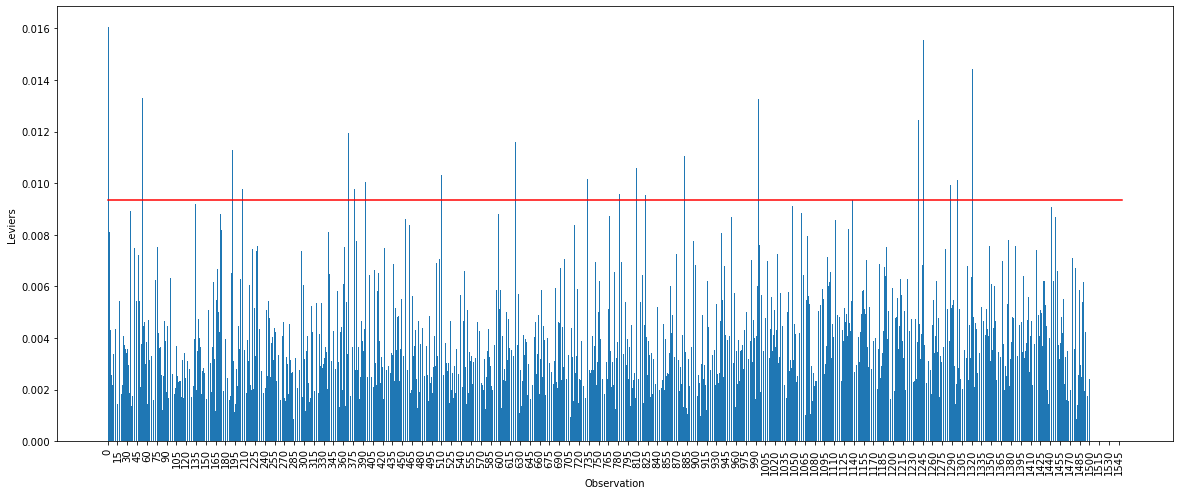

In [4]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n+50, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n+50], [seuil_levier, seuil_levier], color='r')
plt.xticks(np.arange(0, 1550, step = 15), rotation='vertical')
plt.show()

In [5]:
# liste des objets au dessus du seuil_levier

valeurs_levier = analyses.loc[analyses['levier'] > seuil_levier, :]
display(valeurs_levier)
print(len(valeurs_levier))

,obs,levier
0,1,0.016051
52,53,0.013320
190,191,0.011283
205,206,0.009783
367,368,0.011946
376,377,0.009761
393,394,0.010042
479,480,0.011274
509,510,0.010317
622,623,0.011618


33


In [6]:
#  analyses des résidus studentisés

analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

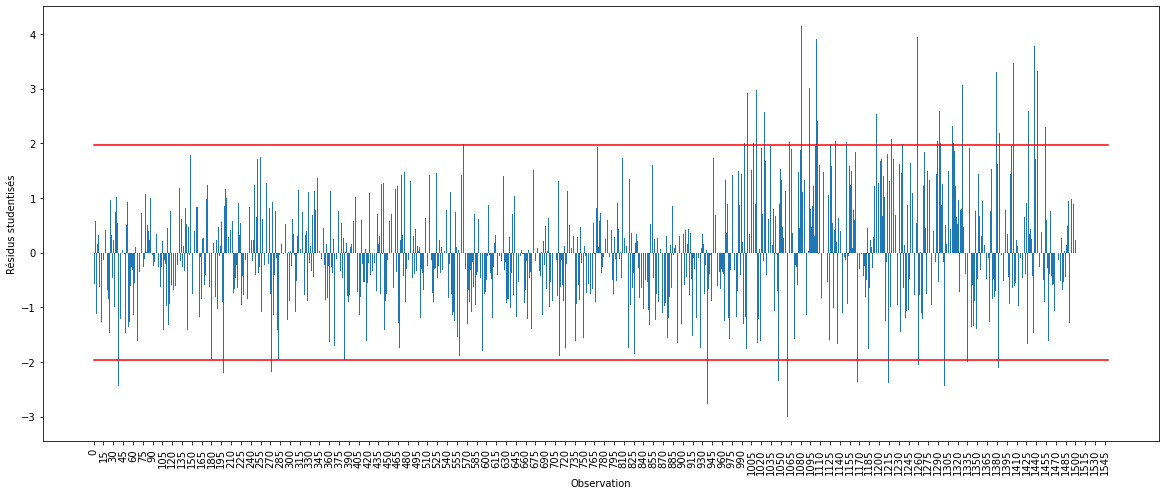

In [7]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n+50, step=5))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n+50], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n+50], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.xticks(np.arange(0, 1550, step = 15), rotation='vertical')
plt.show()

In [8]:
influence = reg_multi.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

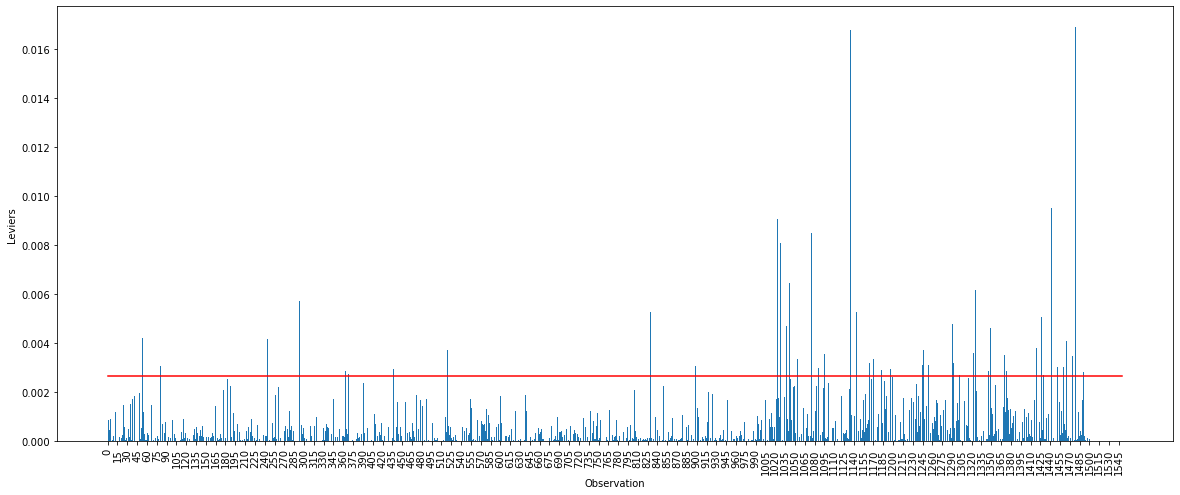

In [9]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n+50, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n+50], [seuil_dcook, seuil_dcook], color='r')
plt.xticks(np.arange(0, 1550, step = 15), rotation='vertical')
plt.show()

In [10]:
valeurs_atypiques_n = analyses.loc[analyses['rstudent'] < -seuil_rstudent, :]
valeurs_atypiques_p = analyses.loc[analyses['rstudent'] > seuil_rstudent, :]
valeurs_atypiques = pd.concat([valeurs_atypiques_p, valeurs_atypiques_n])
valeurs_atypiques

,obs,levier,rstudent,dcooks
79,80,0.004775,1.962236,0.000708
285,286,0.006926,2.218019,0.000005
564,565,0.004610,1.986480,0.000881
649,650,0.011465,2.622546,0.000491
993,994,0.013251,2.010736,0.000692
...,...,...,...,...
1299,1300,0.002834,-2.437064,0.000875
1324,1325,0.006367,-1.968136,0.000262
1334,1335,0.005213,-2.008148,0.000225
1381,1382,0.004812,-2.104303,0.000732


In [11]:
# valeurs atypiques et influents

valeurs_influente = valeurs_atypiques.loc[valeurs_atypiques['dcooks'] > seuil_dcook, :]
valeurs_influente

,obs,levier,rstudent,dcooks
1195,1196,0.001645,2.529820,0.002964
1291,1292,0.005490,2.591030,0.003198
1321,1322,0.001089,2.603527,0.003419
1441,1442,0.009081,3.325295,0.009520
1031,1032,0.004978,-2.523895,0.006523


In [12]:
# del value from data

for index in valeurs_influente.index:
    data = data.drop(data.index[index])
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.520000,2.89,112.83
1,1,171.46,103.36,103.66,3.770000,2.99,113.09
2,1,172.69,104.48,103.50,4.400000,2.94,113.16
3,1,171.36,103.91,103.94,3.620000,3.01,113.51
4,1,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.302069,2.93,111.21
1315,0,172.08,104.15,104.17,5.200358,3.40,112.29
1347,0,171.72,104.46,104.12,5.175468,3.61,110.31
1435,0,172.66,104.33,104.41,5.173450,3.56,111.47


In [29]:
# vérification de la non colinéarité des variables

variables = reg_multi.model.exog
ci = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

print("ci =", ci, "\n")

colinearity_flag = 0

for indice in ci:
    if indice > 5:
        flag = 1
if colinearity_flag:
    print("colinearity problem detected for")
else:
    print("no colinearity detected")

ci = [1.012639095526823, 1.14354735079401, 1.225628269156897, 1.4020863492861222, 1.5707153725489915] 

no colinearity detected


In [14]:
# test homoscédasticité ou constance de la variance des résidus

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.1953159506852815e-16


In [15]:
# test de Shapiro

print(shapiro(reg_multi.resid))
print("H0 rejettée, distribution non normale")

ShapiroResult(statistic=0.9853824973106384, pvalue=3.520380167931769e-11)
H0 rejettée, distribution non normale


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rstudent', ylabel='Density'>

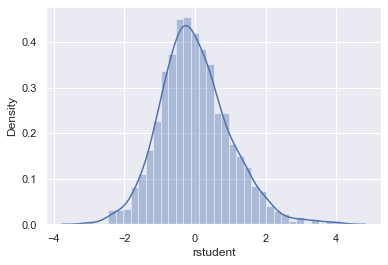

In [16]:
import scipy.stats as stats

sns.set()
sns.distplot(analyses['rstudent'])

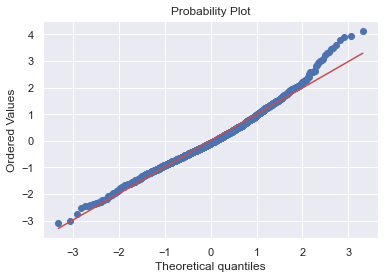

In [17]:
#  droite de henry / qqplot

stats.probplot(analyses['rstudent'], dist="norm", plot=plt)
plt.show()

In [18]:
%store data

Stored 'data' (DataFrame)
